*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# Solving Quadratic Programs with PIPGeq 

In this notebook, we explore how Quadratic Programs can be solved using PIPGeq (https://ieeexplore.ieee.org/document/9295329), an algorithm to solve equality constrained Quadratic Programs with quadratic convergence for solution and cubic convergence for constraint satisfaction for strongly convex cases. It has been designed keeping edge-level MPC in mind.  

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Quadratic Programming in Lava](https://github.com/lava-nc/lava-optimization/blob/main/tutorials/tutorial_01_solving_lasso.ipynb)

### PIPG to solve QPs on Loihi

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The learning rates are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

### Reference Solution

In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import matplotlib.pyplot as plt
import time

In [2]:
a = np.load('qp/data/anymal_small_scale/mpc_240_2000.npz')
Q, A, p, k = [a[i] for i in a] 

In [3]:
Q.shape, A.shape, p.shape, k.shape

((264, 264), (144, 264), (264, 1), (144, 1))

In [4]:
len(Q[Q>0]), len(A[A>0])

(730, 354)

In [5]:
import osqp

Q_ref = sparse.csc_matrix(Q)

A_ref = sparse.csc_matrix(A)

l_eq = k
u_eq = k

#create OSQP object
prob = osqp.OSQP()

prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)

res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1443
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5037e+05   1.40e-01   8.82e+00   1.00e-01   6.78e-04s
  25  -2.3430e+05   1.63e-05   4.19e-05   1.00e-01   3.51e-03s

status:               solved
number of ite

In [6]:
ref_sol_osqp = res.x.reshape((res.x.shape[0], 1)).copy()
opt_objective =  res.info.obj_val

In [7]:
np.linalg.norm(A@ref_sol_osqp)

1.9398772970677445e-05

### Preconditioning the Problem 

We use the ruiz equilibriation class of preconditioners which are a cheap class of diagonal preconditioners that can speed-up the convergence of first-order methods like PIPG to solve QPs. The preconditioner we use is defined below.

In [8]:
def modified_ruiz_preconditioning(H, h, G, steps):
    c = 1
    n = G.shape[0]
    m = H.shape[0]
    
    D = np.eye(m)
    E = np.eye(n)
    
    for k in range(steps):
        H_col_norms = np.linalg.norm(H, ord=np.inf, axis=0)
        G_col_norms = np.linalg.norm(G, ord=np.inf, axis=0)
        
        max_norm_mask = np.greater(H_col_norms, G_col_norms)
        max_col_norms = H_col_norms*max_norm_mask + G_col_norms*(~max_norm_mask)
        G_row_norms =  np.linalg.norm(G, ord=np.inf, axis=1)
        print("||1 - delta||: {}".format(np.max(np.abs(np.concatenate((1-1/np.sqrt(max_col_norms), 1-1/np.sqrt(G_row_norms)))))))    

        max_col_norms[max_col_norms>1e4] = 1e4
        max_col_norms[max_col_norms<1e-4] = 1
        
        G_row_norms[G_row_norms>1e4] = 1e4
        G_row_norms[G_row_norms<1e-4] = 1
        
        D_inter = np.diag(1/max_col_norms)
        E_inter = np.diag(1/G_row_norms)

        
        D_inter = np.sqrt(D_inter)
        E_inter = np.sqrt(E_inter)
        
        H = D_inter@H@D_inter
        G = E_inter@G@D_inter
        
        h = D_inter@h 
        
        D = D@D_inter
        E = E@E_inter
        
#         h_inf_norm =  np.linalg.norm(h, ord=np.inf)
#         if (h_inf_norm < 1e-4):
#             h_inf_norm = 1
        
#         new_col_H_norm = np.linalg.norm(H, ord=np.inf, axis=0)
#         c_temp  = max(np.mean(new_col_H_norm), h_inf_norm)
#         if (c_temp > 1e4):
#             c_temp = 1e4
#         if (c_temp < 1e-4):
#             c_temp = 1
#         gamma = 1.0/c_temp
#         print(c)
#         H*=gamma
#         h*=gamma
#         c*=gamma
    return c, D, E, H, G, h

In [84]:
c, pre_mat_Q, pre_mat_A, Q_pre, A_pre, p_pre = modified_ruiz_preconditioning(Q, p, A, 20) 
k_pre = pre_mat_A@k

||1 - delta||: 2.434646002100865
||1 - delta||: 5.223329772884783
||1 - delta||: 1.4946602519952057
||1 - delta||: 0.5794493508799847
||1 - delta||: 0.2567614534508864
||1 - delta||: 0.12105372460506403
||1 - delta||: 0.05879824546750356
||1 - delta||: 0.028979224993149977
||1 - delta||: 0.01438613209820172
||1 - delta||: 0.007167380378356736
||1 - delta||: 0.0035772916812919497
||1 - delta||: 0.0017870490684592788
||1 - delta||: 0.0008931256974740176
||1 - delta||: 0.0004464631840495059
||1 - delta||: 0.0002232066814134015
||1 - delta||: 0.0001115971137488625
||1 - delta||: 5.5797000221735615e-05
||1 - delta||: 2.7898110958490818e-05
||1 - delta||: 1.3948958192511185e-05
||1 - delta||: 6.974454774821837e-06


In [8]:
Q_non_zero = Q[np.abs(Q)>0]
A_non_zero = A[np.abs(A)>0]
p_non_zero = p[np.abs(p)>0]

Q_pre_non_zero = Q_pre[np.abs(Q_pre)>0]
A_pre_non_zero = A_pre[np.abs(A_pre)>0]
p_pre_non_zero = p_pre[np.abs(p_pre)>0]

xaxes = 'Weight Range'
yaxes = 'Number of Weights'
titles = ['Hessian','Preconditioned Hessian','Constraints','Preconditioned Constraints', 'linear term', 'Preconditioned Linear term'] 

f,a = plt.subplots(3,2, figsize=(10, 10), dpi=100)
#plt.xscale('log')

a = a.ravel()
data=[Q_non_zero,Q_pre_non_zero, A_non_zero, A_pre_non_zero, p_non_zero, p_pre_non_zero]

bins = [10**x for x in range(-12,5)]
for idx,ax in enumerate(a):
    ax.hist(data[idx], bins)
    ax.set_xscale('log')
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylabel(yaxes)

plt.tight_layout()

# axs[0, 0].hist(Q_pre_non_zero, bins=bins)

#plt.xscale('log')
# plt.title("Weight Histogram for Q_pre matrix") 
# plt.show()

NameError: name 'Q_pre' is not defined

In [98]:
np.linalg.cond(Q_pre), np.linalg.cond(A_pre)

(11.28484274343448, 156.73212796224772)

In [48]:
Q_pre = pre_mat_Q@Q@pre_mat_Q

In [795]:
A_pre = pre_mat_A@A@pre_mat_Q

In [9]:
def ruiz_equilibriation(matrix, iterations):
    #tic = time.time()
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    print(row_del)
    #print(time.time()-tic)
    return left_preconditioner, right_preconditioner, m_bar

In [10]:
pre_mat_Q, _, _ = ruiz_equilibriation(Q, 5)
Q_pre = pre_mat_Q@Q@pre_mat_Q
p_pre = pre_mat_Q@p

pre_mat_A, _, _ = ruiz_equilibriation(A, 5)
A_pre = pre_mat_A@A@pre_mat_Q
k_pre = pre_mat_A@k

0.002575085548590872
0.635222951730392


In [11]:
pre_mat_A.shape, pre_mat_Q.shape, A_pre.shape

((144, 144), (264, 264), (144, 264))

### Solver Learning Learning rates 

We have empirically determined these values of solver learning rates parameters to work for our problem

In [8]:
mu, sigma, lamda =  0.11, 8.14, 1.6

We have alpha and beta given for the algorithms as follows 

In [9]:
def alpha_pipg(k):
    return 2/((k+1)*mu + 2*lamda)

def beta_pipg(k):
    return (k+1)*mu/(2*sigma)

In [10]:
alpha_l, beta_l  = [], []
for i in range(1000):
    alpha_l.append(alpha_pipg(i))
    beta_l.append(beta_pipg(i))

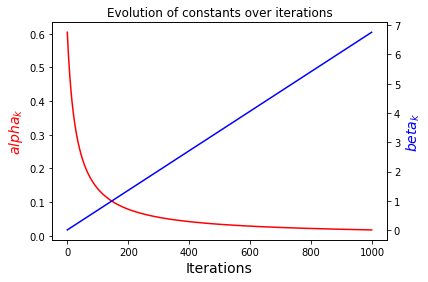

In [11]:
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_l, color="red")
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_l,color="blue")
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
plt.show()

For Lava, the evolution of alpha and beta cannot has to be controlled by right (decrease) and left shifts (increase). Keeping this in mind we inspect the above graph and choose the following decay indices.

In [12]:
alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

In [14]:
alpha_lava_l , beta_lava_l = [], []
alpha_lava, beta_lava = alpha_pipg(0), beta_pipg(0)
alpha_lava_l.append(alpha_lava)
beta_lava_l.append(beta_lava)
for i in range(1000):
    if (i in alpha_decay_indices_list):
        alpha_lava/=2
    if (i in beta_growth_indices_list):
        beta_lava*=2
        
    alpha_lava_l.append(alpha_lava)
    beta_lava_l.append(beta_lava)
   

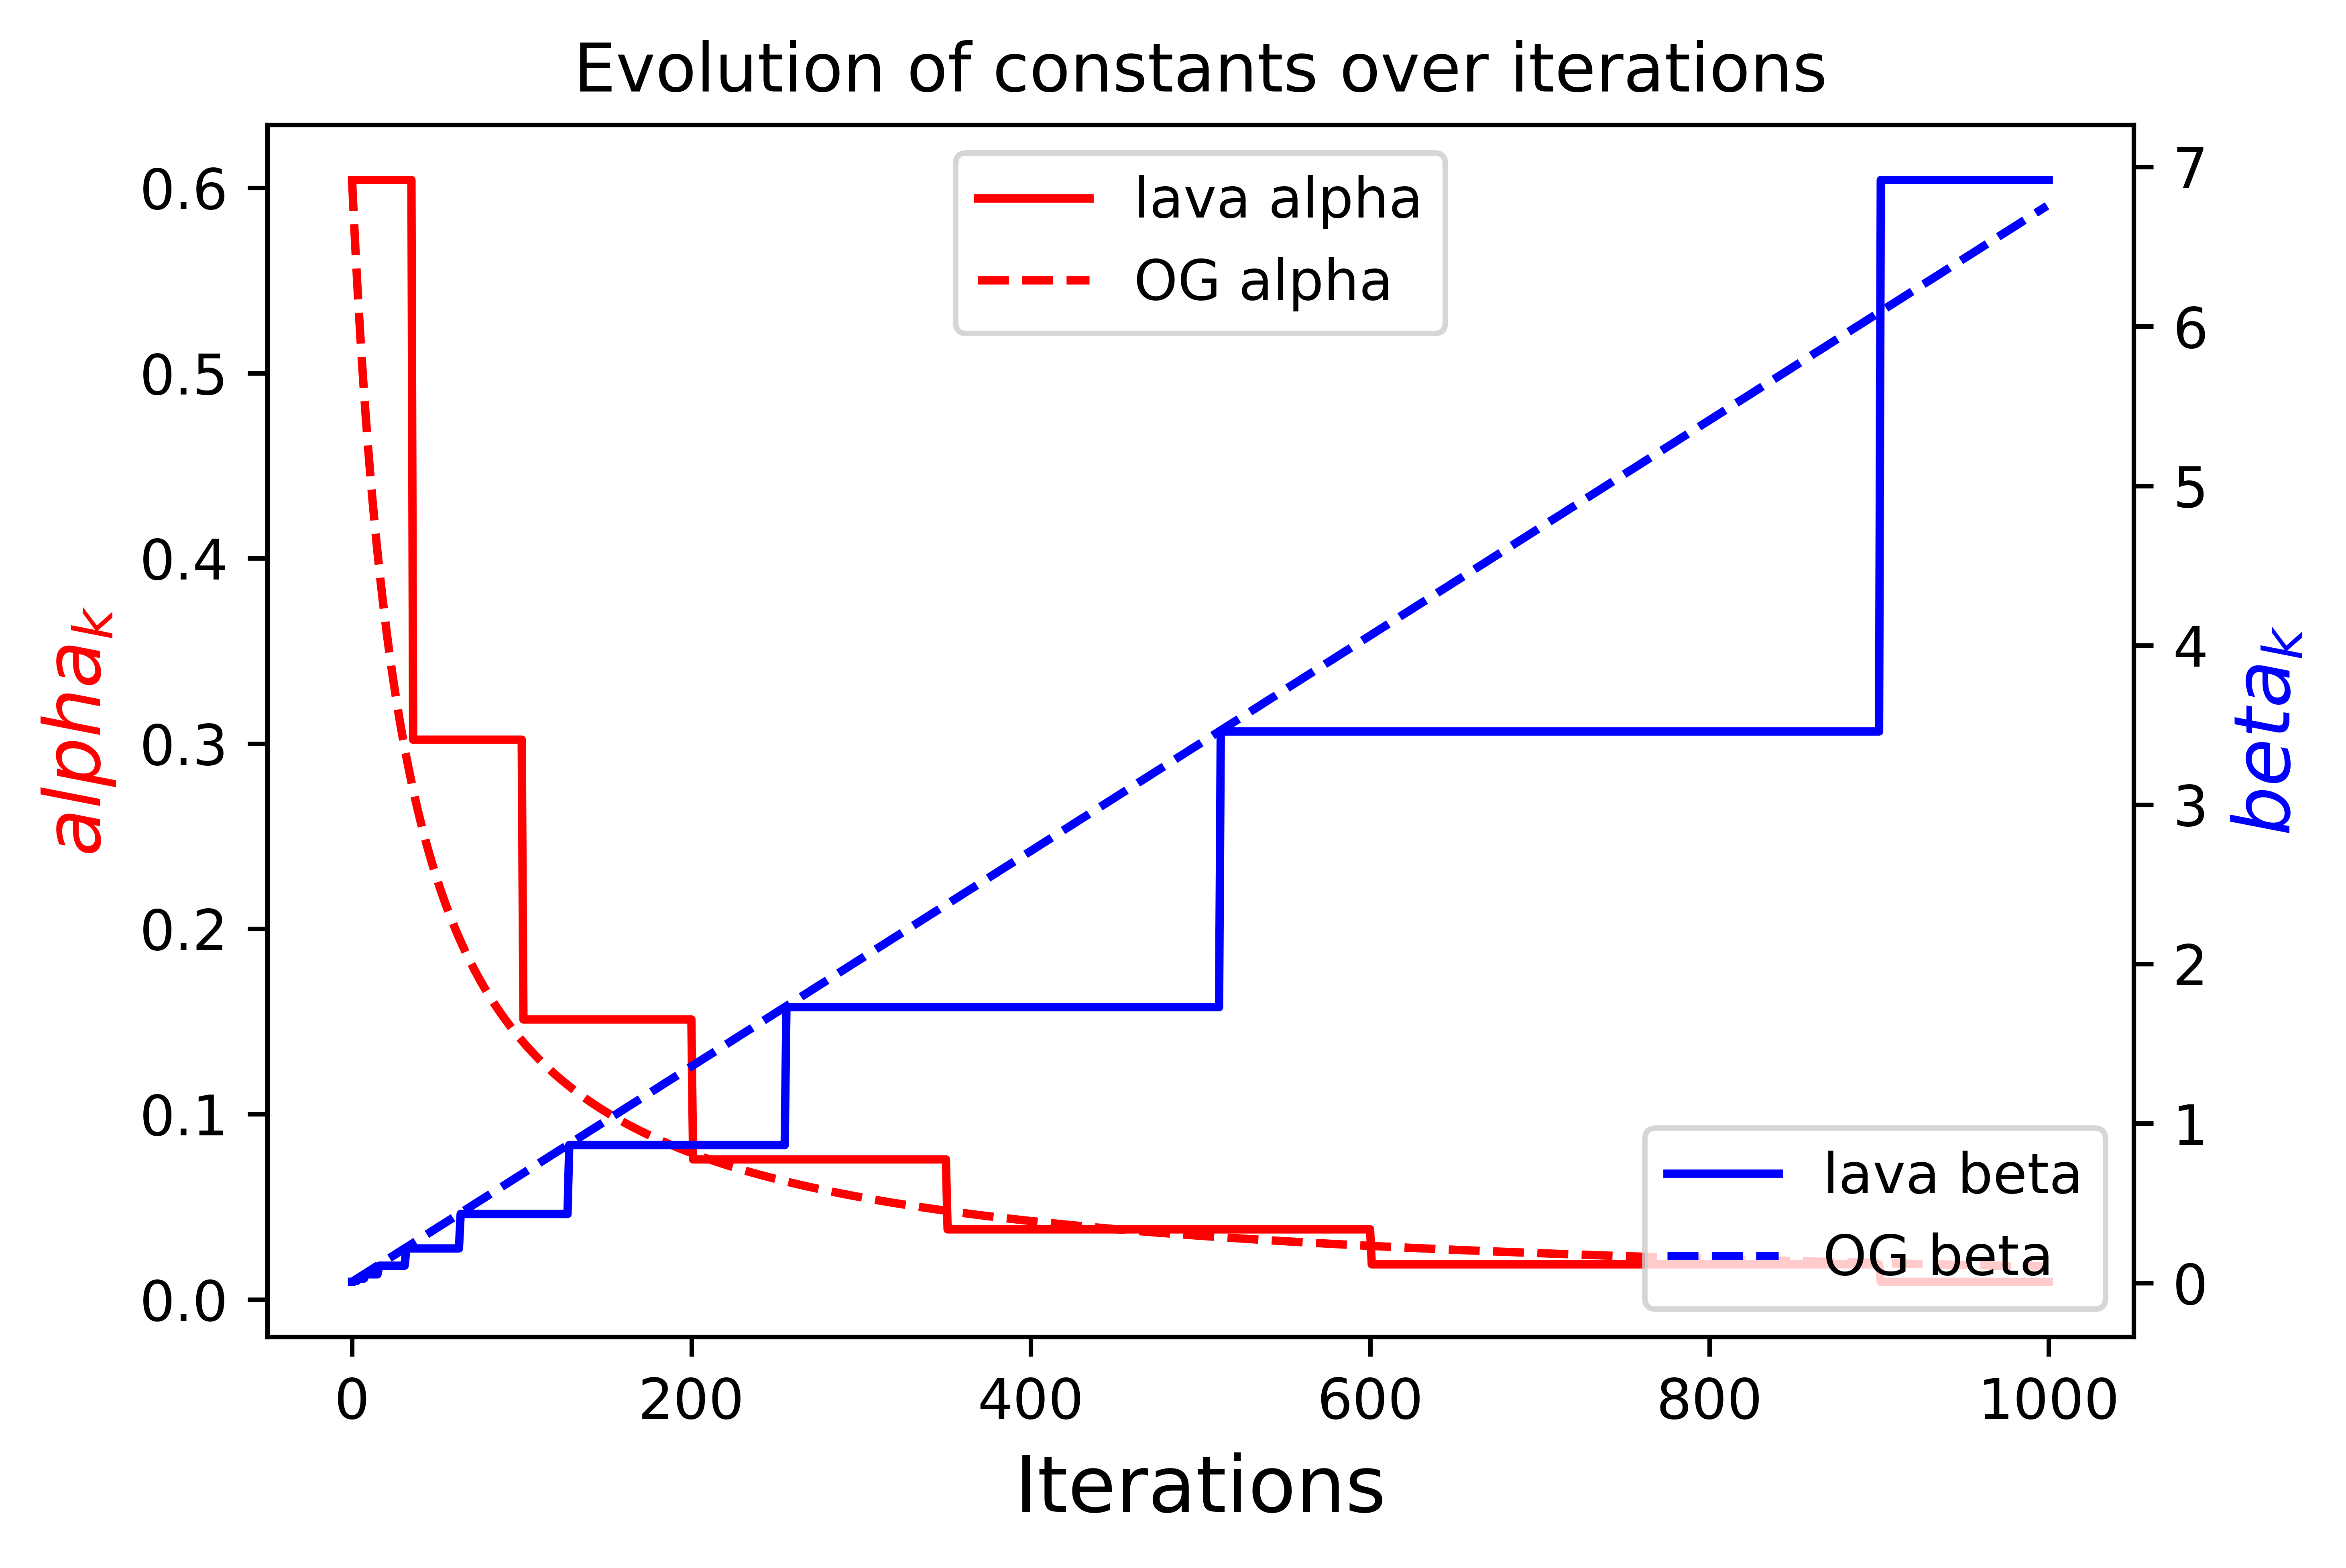

In [20]:
fig,ax = plt.subplots(dpi=1000)
plt.title("Evolution of constants over iterations")
ax.plot(alpha_lava_l, color="red", label='lava alpha')
ax.plot(alpha_l,'--', color="red", label='OG alpha')
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$ alpha_k $",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_lava_l,color="blue", label='lava beta')
ax2.plot(beta_l,'--', color="blue", label='OG beta')
ax2.set_ylabel("$ beta_k $",color="blue",fontsize=14)
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
plt.show()

### Lava PIPG solver

Now we put things together and run the PIPG solver in Lava

In [20]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ConstraintDirections,
    ConstraintNormals,
    QuadraticConnectivity,
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
    SigmaNeurons,
    DeltaNeurons
)

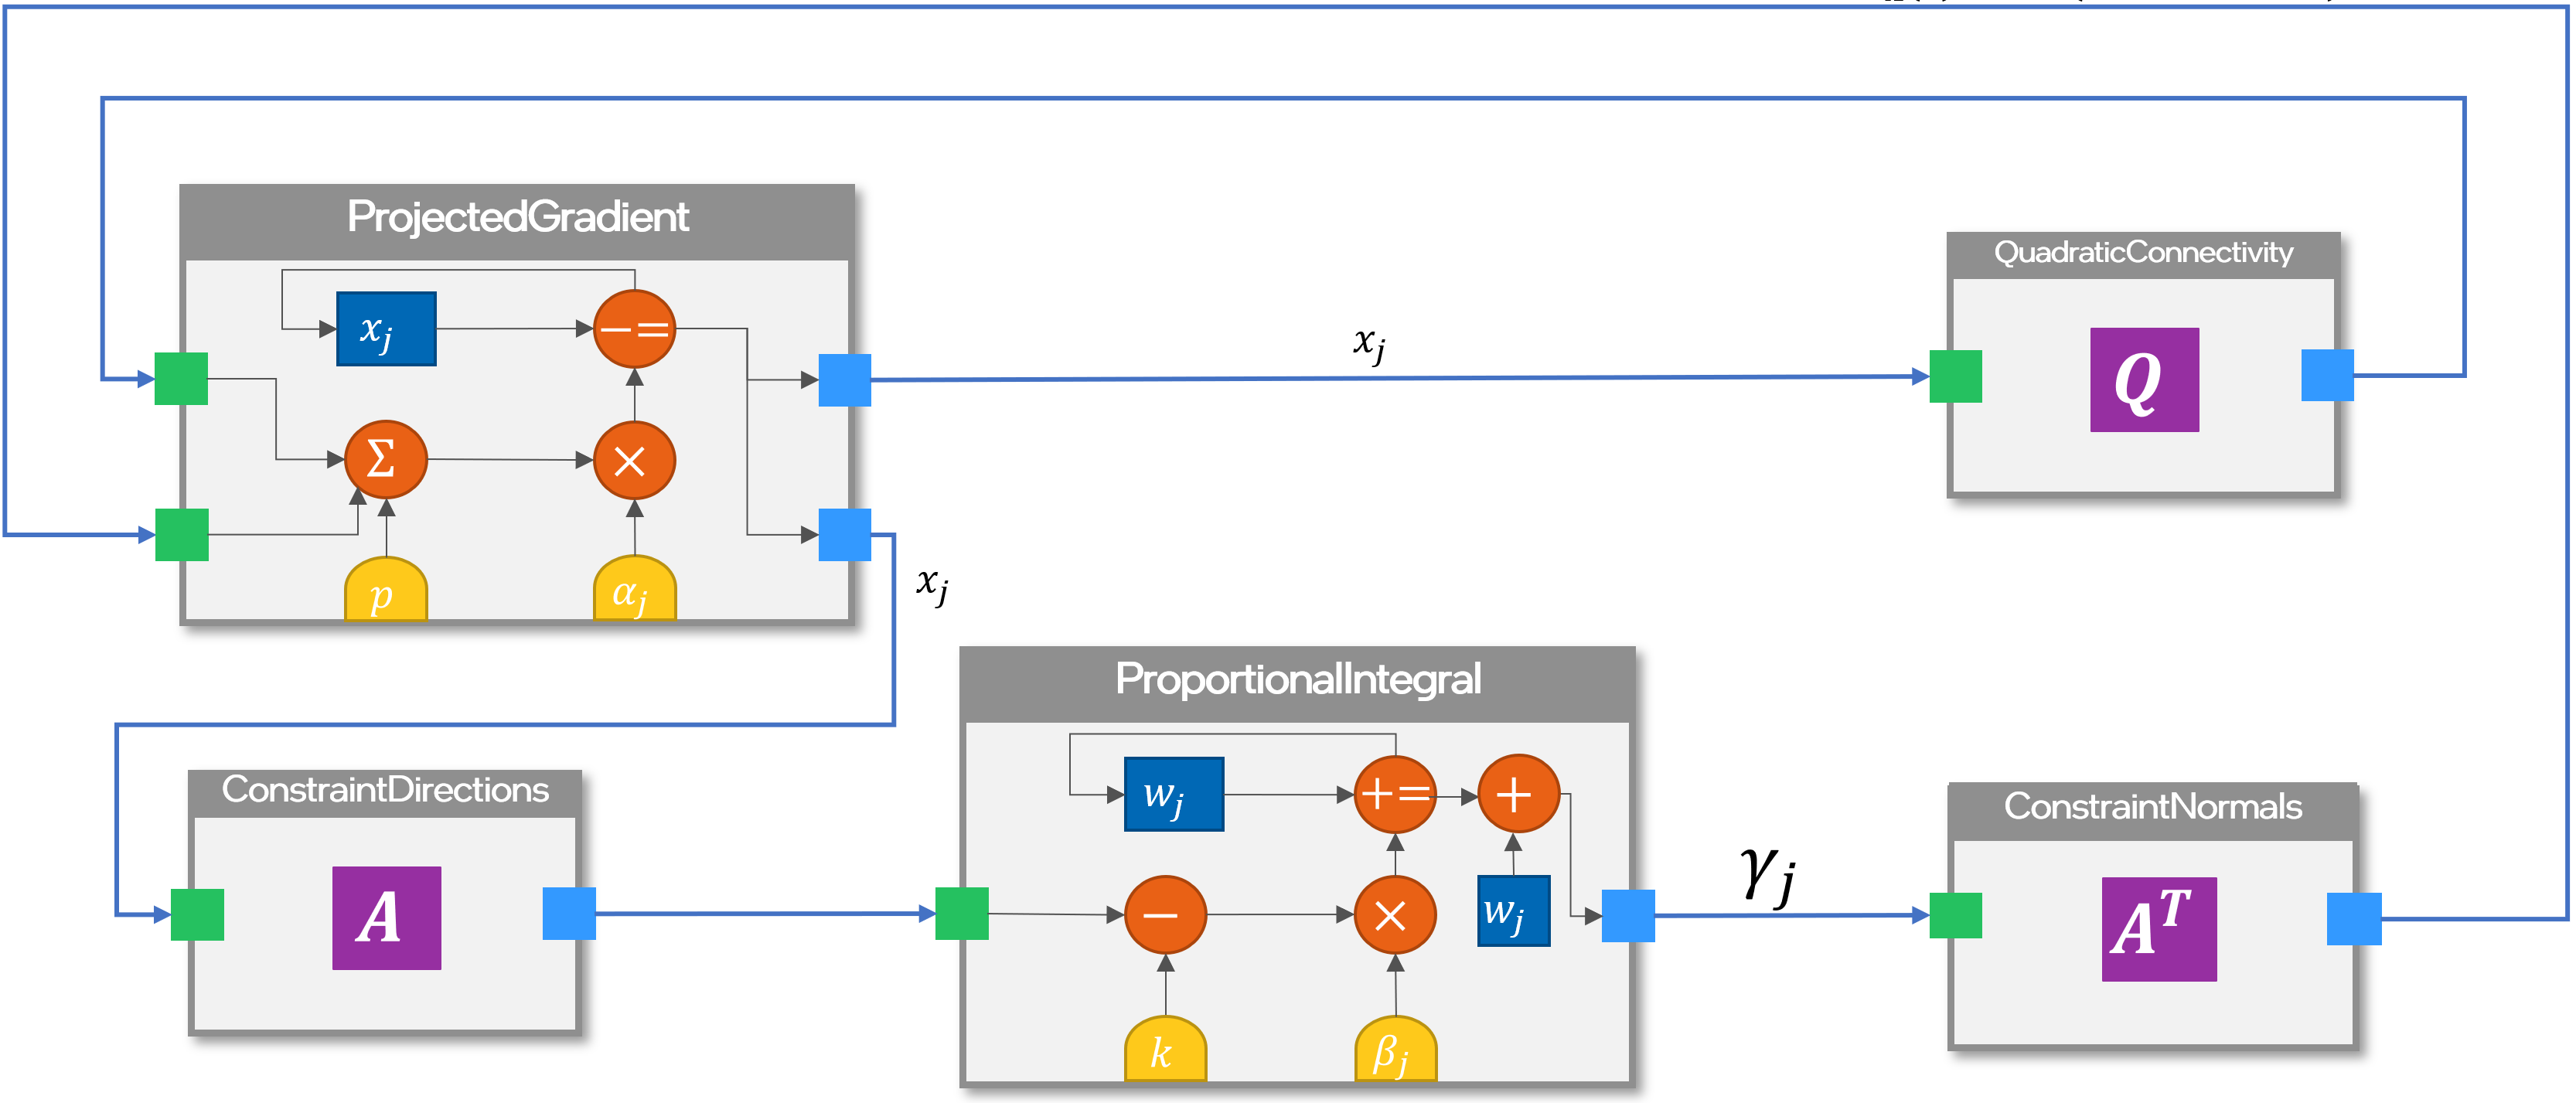

In [17]:
iterations = 475

In [18]:
np.random.seed(10)
# Lava process Initalization for PIPGeq
# Neuron Processes
ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=np.random.rand(p_pre.shape[0], 1),
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                           constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                           thresholds=k_pre,
                                           beta=beta_pipg(0),
                                           lr_growth_type = 'indices',
                                           beta_growth_indices = beta_growth_indices_list 
                                           )

# Connection Processes
ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

# Connecting Processes together
QuadConn.a_out.connect(ProjGrad.a_in_qc)
ConsNorm.a_out.connect(ProjGrad.a_in_cn)
ProjGrad.s_out_qc.connect(QuadConn.s_in)
ProjGrad.s_out_cd.connect(ConsDir.s_in)
ConsDir.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(ConsNorm.s_in)

# Run solver dynamics QP
toc = time.time()
ProjGrad.run(condition=RunSteps(num_steps=iterations),
                      run_cfg=Loihi1SimCfg()
                     )

# get pre-conditioned solution 
pre_sol_k = ProjGrad.vars.qp_neuron_state.get()

# Profiling data
tot_synops = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
tot_spikeops = ProInt.vars.spikeops.get() + ProjGrad.vars.spikeops.get() 

# stop process execution
ProjGrad.stop()

tic = time.time()
print("Solution in {} seconds".format(tic-toc))

# postconditioning to get actual solution
sol_k =  pre_mat_Q@pre_sol_k

Solution in 21.279162168502808 seconds


In [19]:
sol_k_prev = sol_k.copy()

In [20]:
print("The constraint violation residual is {}".format(np.linalg.norm(A@sol_k-k)))

The constraint violation residual is 0.8601261568793737


In [21]:
print("Solution Percentage error is {}".format(np.linalg.norm(ref_sol_osqp - sol_k)/np.linalg.norm(ref_sol_osqp)*100))

Solution Percentage error is 0.01852659422849688


In [22]:
iterations+=1
np.random.seed(10)
# Lava process Initalization for PIPGeq
# Neuron Processes
ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=np.random.rand(p_pre.shape[0], 1),
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                           constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                           thresholds=k_pre,
                                           beta=beta_pipg(0),
                                           lr_growth_type = 'indices',
                                           beta_growth_indices = beta_growth_indices_list 
                                           )

# Connection Processes
ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

# Connecting Processes together
QuadConn.a_out.connect(ProjGrad.a_in_qc)
ConsNorm.a_out.connect(ProjGrad.a_in_cn)
ProjGrad.s_out_qc.connect(QuadConn.s_in)
ProjGrad.s_out_cd.connect(ConsDir.s_in)
ConsDir.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(ConsNorm.s_in)

# Run solver dynamics QP
toc = time.time()
ProjGrad.run(condition=RunSteps(num_steps=iterations),
                      run_cfg=Loihi1SimCfg()
                     )

# get pre-conditioned solution 
pre_sol_k = ProjGrad.vars.qp_neuron_state.get()

# Profiling data
tot_synops = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
tot_spikeops = ProInt.vars.spikeops.get() + ProjGrad.vars.spikeops.get() 

# stop process execution
ProjGrad.stop()

tic = time.time()
print("Solution in {} seconds".format(tic-toc))

# postconditioning to get actual solution
sol_k =  pre_mat_Q@pre_sol_k

Solution in 22.237237453460693 seconds


In [23]:
sol_k_curr = sol_k.copy()

In [24]:
print("The primal residual is {} and the dual residual is {}".format(np.linalg.norm(A@sol_k_curr-A@sol_k_prev, ord=np.inf), 
                                                                     np.linalg.norm(sol_k_curr-sol_k_prev, ord=np.inf)))

The primal residual is 0.015500140709718835 and the dual residual is 0.8656916799063765


### Solver Sparsification

We use Sigma-Delta coding to sparsify the output activity of neurons. First we start with a reference problem  

In [25]:
print("For reference, number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format( 
                                                                                     tot_synops/iterations, tot_spikeops/iterations))
ref_grad = -(Q_pre@pre_sol_k + p_pre) 
ref_sol = (pre_mat_Q@pre_sol_k).copy()
ref_synops = tot_synops.copy()

For reference, number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]



Next we use a sparsification schedule that uses a constant value of theta, i.e the delta spiking threshold for the problem remains constant

In [26]:
thetas = [0, 0.001, 0.01, 0.2, 0.5]
accuracies_ct = []
relative_ops_ct = []
grad_sim_ct = []

np.random.seed(10)
qp_init = np.random.rand(p_pre.shape[0], 1)

for theta in thetas:
    ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=qp_init,
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

    ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                               constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                               thresholds=k_pre,
                                               beta=beta_pipg(0),
                                               lr_growth_type = 'indices',
                                               beta_growth_indices = beta_growth_indices_list 
                                               )
        
    # Connection Processes
    ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
    ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
    QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)
    
    # Delta Neuron process, same initial value as qp_init
    # theta_decay_schedule set to 10000 to maintain constant theta till 10000 iterations
    delNeur = DeltaNeurons(shape=qp_init.shape,
                           x_del_init=qp_init,
                           theta=theta,
                           theta_decay_schedule=10000,
                            )
    

    
    # Connecting Processes together, adding sparsifying processes in between
    QuadConn.a_out.connect(ProjGrad.a_in_qc)
    ConsNorm.a_out.connect(ProjGrad.a_in_cn)
    
    ProjGrad.s_out_qc.connect(delNeur.s_in)
    delNeur.s_out.connect(QuadConn.s_in)

    
    delNeur.s_out.connect(ConsDir.s_in)
    ConsDir.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(ConsNorm.s_in)
    


    # Run solver dynamics QP
    toc = time.time()
    ProjGrad.run(condition=RunSteps(num_steps=iterations),
                          run_cfg=Loihi1SimCfg()
                         )

    # get pre-conditioned solution 
    pre_sol_k_ct = ProjGrad.vars.qp_neuron_state.get()
   
    # Profiling data for constant theta
    tot_synops_ct = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
    tot_spikeops_ct = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

    # stop process execution
    ProjGrad.stop()
    
    grad_ct = -(Q_pre@pre_sol_k_ct + p_pre) 
    print("Finished calcuations for constant theta={} in {} seconds".format(theta, time.time()-toc))

    # Append stats for constant theta to a list
    grad_sim_ct.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_ct.reshape(grad_ct.shape[0],)))
    accuracies_ct.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_ct))/np.linalg.norm(ref_sol)*100)
    relative_ops_ct.append((ref_synops/tot_synops_ct).squeeze(axis=0))
    print("For constant theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                     tot_synops_ct/iterations, tot_spikeops_ct/iterations))
    

Finished calcuations for constant theta=0 in 25.12099862098694 seconds
For constant theta=0 number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]

Finished calcuations for constant theta=0.001 in 22.015489101409912 seconds
For constant theta=0.001 number of operations per iteration 
 Syn Ops: [[47124.03991597]] 
 Spike Ops: [[6954.94117647]]

Finished calcuations for constant theta=0.01 in 21.47962474822998 seconds
For constant theta=0.01 number of operations per iteration 
 Syn Ops: [[43299.55042017]] 
 Spike Ops: [[6416.88865546]]

Finished calcuations for constant theta=0.2 in 21.485417127609253 seconds
For constant theta=0.2 number of operations per iteration 
 Syn Ops: [[35203.13235294]] 
 Spike Ops: [[5239.45378151]]

Finished calcuations for constant theta=0.5 in 21.505054712295532 seconds
For constant theta=0.5 number of operations per iteration 
 Syn Ops: [[32651.67016807]] 
 Spike Ops: [[4906.71218487]]



In [27]:
# postconditioning to get actual solution
sol_k =  pre_mat_Q@pre_sol_k_ct
print("Solution Percentage error is {}".format(np.linalg.norm(ref_sol_osqp - sol_k)/np.linalg.norm(ref_sol_osqp)*100))

Solution Percentage error is 8.422246645020204


We now use adaptive theta to vary the thresholding as the number of iterations increase

In [28]:
thetas = [0, 0.001, 0.01, 0.2, 0.5, 1, 2, 10, 20]
#thetas = [0, 10, 15, 20, 25, 50]
#thetas = [10]
accuracies_at = []
relative_ops_at = []
grad_sim_at = []


np.random.seed(10)
qp_init = np.random.rand(p_pre.shape[0], 1)

for theta in thetas:
    ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=qp_init,
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

    ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                               constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                               thresholds=k_pre,
                                               beta=beta_pipg(0),
                                               lr_growth_type = 'indices',
                                               beta_growth_indices = beta_growth_indices_list 
                                               )
        
    # Connection Processes
    ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
    ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
    QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)
    
    # Delta Neuron process, same initial value as qp_init
    # theta_decay_schedule set to 50 
#     delNeur = DeltaNeurons(shape=qp_init.shape,
#                            x_del_init=qp_init,
#                            theta=theta,
#                            theta_decay_type = 'indices',
#                            theta_decay_indices = alpha_decay_indices_list
#                             )
    delNeur = DeltaNeurons(shape=qp_init.shape,
                       x_del_init=qp_init,
                       theta=theta,
                       theta_decay_schedule = 60
                        )

    
    # Connecting Processes together, adding sparsifying processes in between
    QuadConn.a_out.connect(ProjGrad.a_in_qc)
    ConsNorm.a_out.connect(ProjGrad.a_in_cn)
    
    ProjGrad.s_out_qc.connect(delNeur.s_in)
    delNeur.s_out.connect(QuadConn.s_in)

    
    delNeur.s_out.connect(ConsDir.s_in)
    ConsDir.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(ConsNorm.s_in)
    

    # Run solver dynamics QP
    toc = time.time()
    ProjGrad.run(condition=RunSteps(num_steps=iterations),
                          run_cfg=Loihi1SimCfg()
                         )

    # get pre-conditioned solution 
    pre_sol_k_at = ProjGrad.vars.qp_neuron_state.get()
   
    # Profiling data for constant theta
    tot_synops_at = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
    tot_spikeops_at = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

    # stop process execution
    ProjGrad.stop()
    
    grad_at = -(Q_pre@pre_sol_k_at + p_pre) 
    print("Finished calcuations for adaptive theta={} in {} seconds".format(theta, time.time()-toc))

    # Append stats for constant theta to a list
    grad_sim_at.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_at.reshape(grad_at.shape[0],)))
    accuracies_at.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_at))/np.linalg.norm(ref_sol)*100)
    relative_ops_at.append((ref_synops/tot_synops_at).squeeze(axis=0))
    print("For adaptive theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                     tot_synops_at/iterations, tot_spikeops_at/iterations))
    

Finished calcuations for adaptive theta=0 in 21.64599871635437 seconds
For adaptive theta=0 number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]

Finished calcuations for adaptive theta=0.001 in 21.28634476661682 seconds
For adaptive theta=0.001 number of operations per iteration 
 Syn Ops: [[48455.94117647]] 
 Spike Ops: [[7143.48739496]]

Finished calcuations for adaptive theta=0.01 in 21.44595980644226 seconds
For adaptive theta=0.01 number of operations per iteration 
 Syn Ops: [[47082.63235294]] 
 Spike Ops: [[6939.59453782]]

Finished calcuations for adaptive theta=0.2 in 21.45403504371643 seconds
For adaptive theta=0.2 number of operations per iteration 
 Syn Ops: [[42417.32983193]] 
 Spike Ops: [[6300.92436975]]

Finished calcuations for adaptive theta=0.5 in 21.40991711616516 seconds
For adaptive theta=0.5 number of operations per iteration 
 Syn Ops: [[40254.95588235]] 
 Spike Ops: [[5997.14705882]]

Finished calcuations for adaptive theta=1 in 21.6

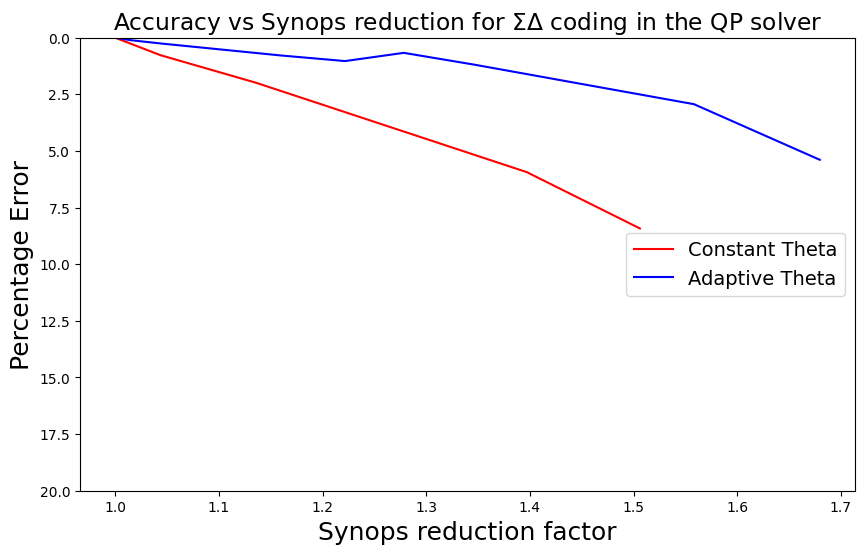

In [29]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 14})
plt.title("Accuracy vs Synops reduction for $ \Sigma \Delta $ coding in the QP solver")
ax.plot(relative_ops_ct, accuracies_ct, color="red", label='Constant Theta')
ax.set_ylabel("Percentage Error",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(20,0)
ax.plot(relative_ops_at, accuracies_at, color="blue", label='Adaptive Theta')
ax.set_xlabel("Synops reduction factor",fontsize=18)
ax.legend(loc="center right")
plt.show()

In [30]:
accuracies_ct, accuracies_at

([0.0,
  0.7707617308885506,
  1.9882554151806269,
  5.9341464281870575,
  8.422066416189594],
 [0.0,
  0.10878732152715771,
  0.25726563896148597,
  0.7819143286772227,
  1.0309968243385026,
  0.6679861683567171,
  1.185702561717655,
  2.934423382979977,
  5.389738358670821])

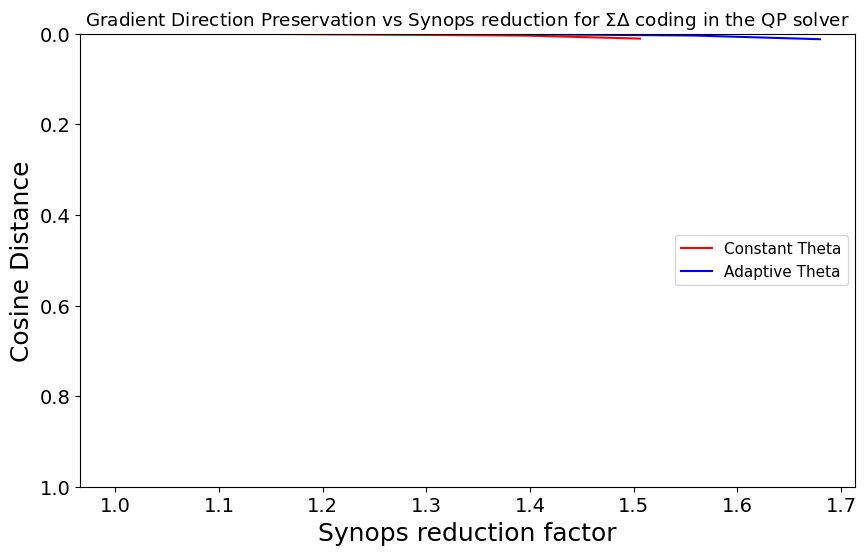

In [31]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 11})
plt.title("Gradient Direction Preservation vs Synops reduction for $ \Sigma \Delta $ coding in the QP solver")
ax.plot(relative_ops_ct, grad_sim_ct, color="red", label='Constant Theta')
ax.set_ylabel("Cosine Distance",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(1, 0)
ax.plot(relative_ops_at, grad_sim_at, color="blue", label='Adaptive Theta')
ax.set_xlabel("Synops reduction factor",fontsize=18)
ax.legend(loc="center right")
plt.show()

### Fixed Point Conversion

An added advantage of pre-conditioning apart from making the first-order method faster is to reduce the dynamic range of the system. This can aid the fixed-point conversion process. We first conduct an analysis of the static variables in our problem, namely $Q, A$ and $p$

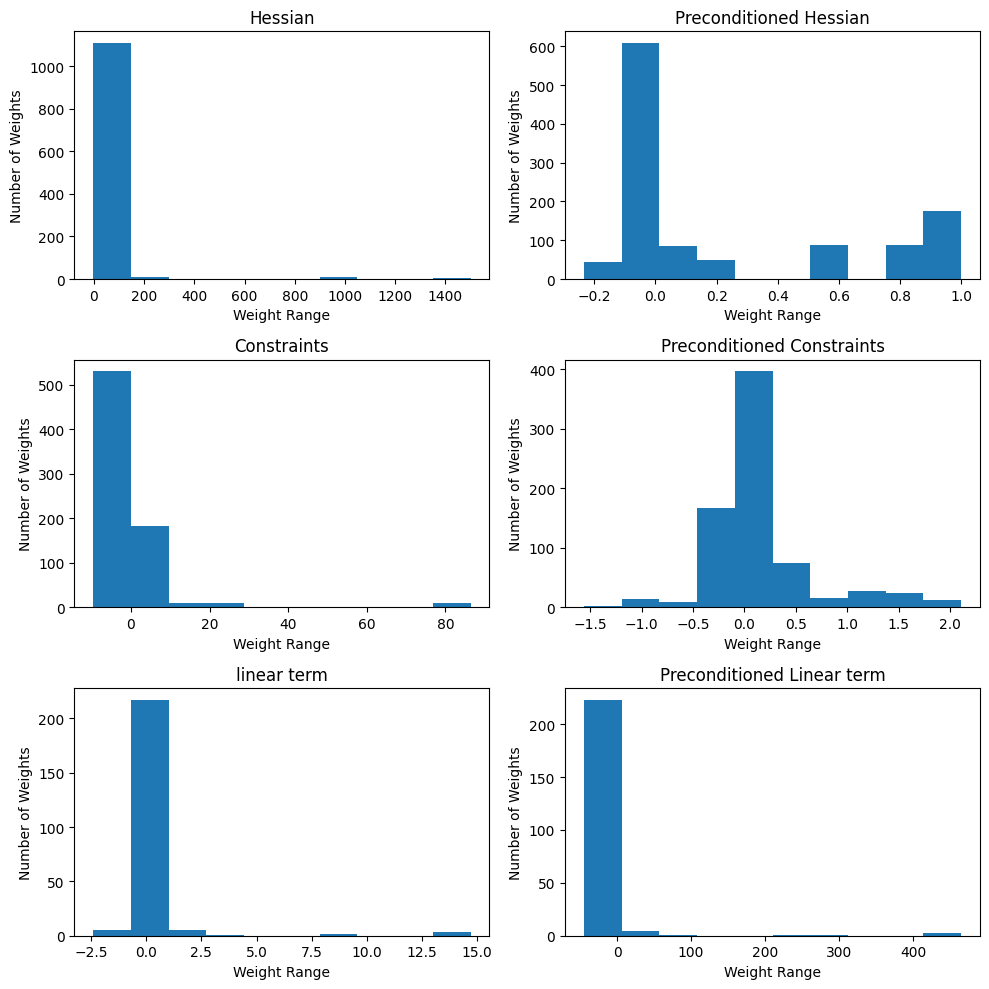

In [20]:
Q_non_zero = Q[np.abs(Q)>0]
A_non_zero = A[np.abs(A)>0]
p_non_zero = p[np.abs(p)>0]

Q_pre_non_zero = Q_pre[np.abs(Q_pre)>0]
A_pre_non_zero = A_pre[np.abs(A_pre)>0]
p_pre_non_zero = p_pre[np.abs(p_pre)>0]

xaxes = 'Weight Range'
yaxes = 'Number of Weights'
titles = ['Hessian','Preconditioned Hessian','Constraints','Preconditioned Constraints', 'linear term', 'Preconditioned Linear term'] 

f,a = plt.subplots(3,2, figsize=(10, 10), dpi=100)
#plt.xscale('log')

a = a.ravel()
data=[Q_non_zero,Q_pre_non_zero, A_non_zero, A_pre_non_zero, p_non_zero, p_pre_non_zero]

# bins = [10**x for x in range(-12,5)]
for idx,ax in enumerate(a):
    ax.hist(data[idx])
#     ax.set_xscale('log')
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylabel(yaxes)

plt.tight_layout()

# axs[0, 0].hist(Q_pre_non_zero, bins=bins)

#plt.xscale('log')
# plt.title("Weight Histogram for Q_pre matrix") 
# plt.show()
# print("Histogram values: {}".format(n))

Now we need to check for the range of  dynamic variables x and w for fixed point conversion. We do so by running PIPG in floating-point till completion and checking for the maximum values that occur in the intermediate operations

In [22]:
eigvals_Q_pre = np.linalg.eigvals(Q_pre)
mu = np.min(eigvals_Q_pre)    # lowest eigen value of cost matrix H
sigma = np.max(np.linalg.eigvals(A_pre.T@A_pre)) # Highest eigen value of G^TG
lamda = np.max(eigvals_Q_pre) # Highest eigen value of cost matrix H

In [23]:
mu, sigma, lamda

(0.1351797258129727, (6.441859885054692+0j), 1.5254819478999884)

In [24]:
# mu, sigma, lamda =  0.11, 8.14, 1.6
alpha_pipg(0), beta_pipg(0)

(0.6277180935702837, (0.010492290132434712+0j))

In [21]:
 # PIPG constants 
mu, sigma, lamda =  0.11, 8.14, 1.6 # Ruiz
# mu, sigma, lamda =  0.027, 10.45, 1.8 # modified Ruiz
alpha_lava = alpha_pipg(0)
beta_lava = beta_pipg(0)

# PIPG init
np.random.seed(10)
w = np.random.rand(A.shape[0],1) 
x = np.random.rand(A.shape[1],1)
v= np.random.rand(A.shape[0],1)

sol = []
constraint_sat = []
cost = []
k_max=2000 

w_max_val = 0
x_max_val = 0
v_max_val = 0

w_min_val = 0
x_min_val = 0
v_min_val = 0

toc = time.time()
for i in range(k_max):
    if (i in alpha_decay_indices_list ):
        alpha_lava/=2
    if (i in beta_growth_indices_list):
        beta_lava*=2

    Q_pre_dot_x = Q_pre@x
    A_pre_T_dot_v = A_pre.T@v 
    x_decrement = Q_pre_dot_x + p_pre + A_pre_T_dot_v
    x = x - alpha_lava * (x_decrement)
    x_min_val = min(np.amin(x), np.amin(Q_pre_dot_x), np.amin(A_pre_T_dot_v), 
                    np.amin(x_decrement), np.amin(p_pre), x_min_val)
    x_max_val = max(np.amax(x), np.amax(Q_pre_dot_x), np.amax(A_pre_T_dot_v), 
                    np.amax(x_decrement), np.amax(p_pre), x_max_val)
    
    A_pre_dot_x = A_pre@x
    gamma =  beta_lava * (A_pre_dot_x - k_pre)
    w += gamma
    w_min_val =  min(w_min_val, np.amin(w), np.amin(gamma), np.amin(A_pre_dot_x))
    w_max_val =  max(w_max_val, np.amax(w), np.amax(gamma), np.amax(A_pre_dot_x))
    v = w + gamma
    v_min_val = min(v_min_val, np.amin(v))
    v_max_val = max(v_max_val, np.amax(v))
    
    #cost.append(np.abs((z.T@H_pre@z/2 + h_pre.T@z) - opt_objective)/np.abs(opt_objective)*100)
    sol.append(pre_mat_Q@x)
    #constraint_sat.append(np.linalg.norm(G_pre@z - g_pre))

err_sol = [np.linalg.norm(res.x.reshape((res.x.shape[0], 1)) - s) for s in sol]
err_sol_percent = [np.linalg.norm(ref_sol_osqp - s)/np.linalg.norm(ref_sol_osqp)*100 for s in sol] 
cons_vio_fl = [np.linalg.norm(A@s - k) for s in sol]

print("Found solution in {} seconds with error of {}% ".format(time.time()- toc, err_sol_percent[-1]))
print("The max val of \n w: {} \n v:{} \n x:{}".format(w_max_val, v_max_val, x_max_val))
print("The min val of \n w: {} \n v:{} \n x:{}".format(w_min_val, v_min_val, x_min_val))

Found solution in 3.868194341659546 seconds with error of 0.0003317557626927892% 
The max val of 
 w: 1597.2300059252261 
 v:1597.2319695723588 
 x:465.79394339177503
The min val of 
 w: -1500.7201516559996 
 v:-1500.7219041025462 
 x:-450.48621507530817


We now have a grasp of the range all variables in the algorithm . We are now in a position to proceed with fixed-point conversion of the algorithm. We calculate the exponent and mantissa for different variables involved in algorithm

In [49]:
# construct A_pre_exp by creating mask from range and mantissa matrix from the corresponding exp mat
def convert_to_fp(m_pre, man_bits):
    exp_1 = np.ceil(np.log2(np.max(np.abs(m_pre)))) - man_bits + 1 
    exp_2 = exp_1  - man_bits + 1 
    exp_3 = exp_2  - man_bits + 1
    exp_4 = exp_3  - man_bits + 1
    exp_5 = exp_4  - man_bits + 1
    
    mat_exp_1 =  (2**-exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
    mat_exp_2 = (2**-exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
    mat_exp_3 = (2**-exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
    mat_exp_4 = (2**-exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3
    mat_exp_5 = (2**-exp_5)*(1*(np.abs(m_pre)<2**exp_4) * (1*(np.abs(m_pre)>=2**exp_5))) #ul 2**exp_4


    m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4 + mat_exp_5 
    m_pre_man = np.round(m_pre*m_pre_exp_mat)

    # performing this atrocity because of numpy type error, to be fixed later but behavior is as intended
    mat_exp_1 =  (2**exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
    mat_exp_2 = (2**exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
    mat_exp_3 = (2**exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
    mat_exp_4 = (2**exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3
    mat_exp_5 = (2**exp_5)*(1*(np.abs(m_pre)<2**exp_4) * (1*(np.abs(m_pre)>=2**exp_5))) #ul 2**exp_4

    m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4 + mat_exp_5 
    m_pre_fp = m_pre_man*(m_pre_exp_mat)
    return m_pre_fp

In [22]:
def convert_to_fp(m_pre, man_bits):
    exp_1 = np.ceil(np.log2(np.max(np.abs(m_pre)))) - man_bits + 1 
    exp_2 = exp_1  - man_bits + 1 
    exp_3 = exp_2  - man_bits + 1
    exp_4 = exp_3  - man_bits + 1
    exp_5 = exp_4  - man_bits + 1
    
    mat_exp_1 =  (2**-exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
#     mat_exp_2 = (2**-exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
#     mat_exp_3 = (2**-exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
#     mat_exp_4 = (2**-exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3


#     m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4
    m_pre_exp_mat = mat_exp_1 
    m_pre_man = np.round(m_pre*m_pre_exp_mat)

    # performing this atrocity because of numpy type error, to be fixed later but behavior is as intended
    mat_exp_1 =  (2**exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
#     mat_exp_2 = (2**exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
#     mat_exp_3 = (2**exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
#     mat_exp_4 = (2**exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3

#     m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4 
    m_pre_exp_mat = mat_exp_1
    m_pre_fp = m_pre_man*(m_pre_exp_mat)
    return m_pre_fp

In [40]:
Q_pre_fp = convert_to_fp(Q_pre, 32)
A_pre_fp = convert_to_fp(A_pre, 32)
p_pre_fp = convert_to_fp(p_pre, 18)

In [24]:
np.min(np.abs(Q_pre_fp[np.abs(Q_pre_fp)>0])), np.min(np.abs(Q_pre[np.abs(Q_pre)>0])), np.max(np.abs(Q_pre_fp)),np.max(np.abs(Q_pre))

(1.0058283805847168e-07, 1.0016079393140124e-07, 1.0, 1.0000000000000004)

In [25]:
# pre_A_fp min,pre_A_fp min, pre_A_fullprec max, pre_A_fullprec max  
np.min(np.abs(A_pre_fp[np.abs(A_pre_fp)>0])), np.min(np.abs(A_pre[np.abs(A_pre)>0])), np.max(np.abs(A_pre_fp)),np.max(np.abs(A_pre))

(3.520399332046509e-07,
 3.511564987563083e-07,
 2.107843341305852,
 2.107843341494981)

In [26]:
np.min(np.abs(p_pre_fp[np.abs(p_pre_fp)>0])), np.min(np.abs(p_pre[np.abs(p_pre)>0])), np.max(np.abs(p_pre_fp)),np.max(np.abs(p_pre))

(0.00390625, 3.4360406115640158e-06, 464.828125, 464.8263410217994)

In [27]:
# stochastic rounding function for numpy arrays
def prob_round(x):
    sign = np.sign(x)
    x = abs(x)
    is_up = np.random.random(x.shape) < x-x.astype(int)
    return sign*(np.ceil(is_up*x) + np.floor(np.logical_not(is_up)*x))

In [28]:
mean_x , std_x = np.mean(x), np.std(x)

In [70]:
weight_bits = [8, 16, 24, 32]
ref_grad = -(Q@ref_sol_osqp + p) 

err_sol_fp = dict()
grad_sim = dict()
err_sol_percent_fp = dict()
fp_last_it = dict()
cons_vio =dict()
cons_sat_pre = dict()

for bits in weight_bits:
    # Static Variables
    Q_pre_fp = convert_to_fp(Q_pre, bits)
    A_pre_fp = convert_to_fp(A_pre, bits)
    p_pre_fp = convert_to_fp(p_pre, 18)
    
    # Quasi-static Variables
    alpha_exp = -3
    beta_exp = -7
    beta_man = 1
    alpha_man = 5
    
    # fixed-point PIPG
    beta_fp = beta_man*2**(beta_exp)
    alpha_fp = alpha_man*2**(alpha_exp)

    # Heuristics
    A_pre_del = A_pre - A_pre_fp
#     A_pre_del[np.abs(A_pre_del)<1e-5] = 0
    Q_pre_del = Q_pre - Q_pre_fp
    
    # PIPG init
    np.random.seed(10)
    w_fp = np.zeros((A.shape[0],1)) 
    x_fp = np.zeros((A.shape[1],1))
    v_fp= np.zeros((A.shape[0],1)) 

    sol_fp = []
    constraint_sat = []
    cost = []

    alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
    beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

    ones = np.ones(w_fp.shape)

    k_max=750
    
    x_comp = std_x*np.random.randn(A.shape[1],1) + mean_x
    toc = time.time()
    for i in range(k_max):
        if (i in alpha_decay_indices_list ):
            alpha_fp/=2
        if (i in beta_growth_indices_list):
            beta_fp*=2

        x_fp = x_fp - alpha_fp * (Q_pre_fp@x_fp + p_pre_fp +  A_pre_fp.T@v_fp + A_pre_del.T@v_fp)
            
        gamma =  beta_fp * (A_pre_fp@x_fp)
        w_fp += gamma

        v_fp = w_fp + gamma
        #cost.append(np.abs((z.T@H_pre@z/2 + h_pre.T@z) - opt_objective)/np.abs(opt_objective)*100)
        constraint_sat.append(np.linalg.norm(A_pre_fp@x_fp))
        sol_fp.append(pre_mat_Q@x_fp)
        grad_sol = -(Q@(pre_mat_Q@x_fp) + p) 
    
    fp_last_it[bits] = pre_mat_Q@x_fp
    err_sol_percent_fp[bits] = [np.linalg.norm(ref_sol_osqp - s)/np.linalg.norm(ref_sol_osqp)*100 for s in sol_fp] 
    err_sol_fp[bits] = [np.linalg.norm(ref_sol_osqp - s) for s in sol_fp]
    cons_sat_pre[bits] = constraint_sat
    cons_vio[bits] = [np.linalg.norm(A@s - k) for s in sol_fp]
    grad_sim[bits] = distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_sol.reshape(grad_sol.shape[0],))


In [71]:
# x is solution from floating point PIPG in a recent cell
grad_sol =  -(Q@(pre_mat_Q@x) + p)
grad_sim[64] =  distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_sol.reshape(grad_sol.shape[0],))   

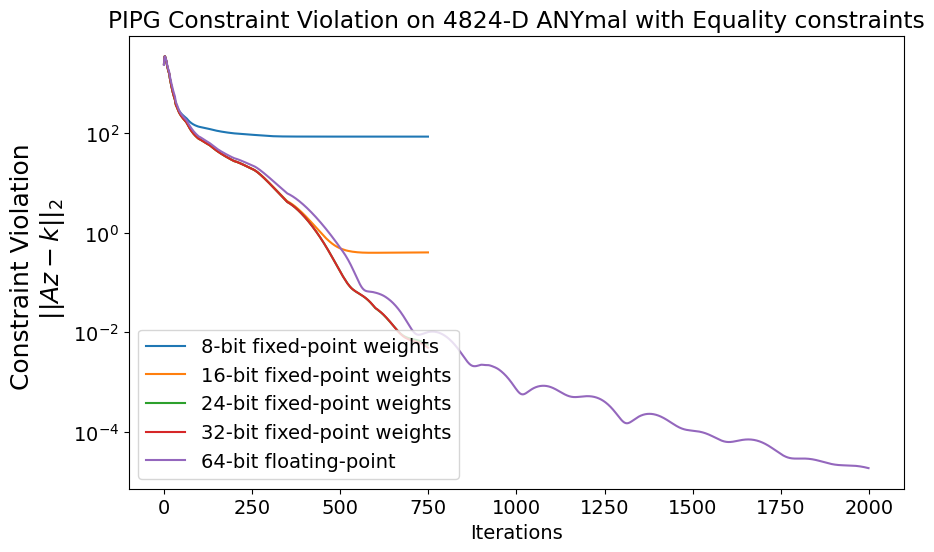

In [72]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 14})
plt.title("PIPG Solver Solution % error on 4824-D ANYmal with Equality constraints")
# make a plot with different y-axis using second axis object
# ax.plot(err_sol_percent_fp[8][:], label= "8-bit fixed-point weights ")
# # ax.plot(err_sol_percent_fp[16][:], label= "16-bit fixed-point weights ")
# # #ax.plot(err_sol_percent_fp[32][:], label= "32-bit fixed-point weights ")
# # ax.plot(err_sol_percent_16_float[:], label= "16-bit floating-point")
# ax.plot(err_sol_percent[:], label= "64-bit floating-point")
#ax.set_ylabel("Sol Error Percentage \n $ ||z*-z||_2/||z*||_2} $ *100",fontsize=18)


# # make a plot with different y-axis using second axis object
plt.title("PIPG Constraint Violation on 4824-D ANYmal with Equality constraints")
ax.set_xlabel("Iterations")
ax.plot(cons_vio[8][:], label= "8-bit fixed-point weights")
ax.plot(cons_vio[16][:], label= "16-bit fixed-point weights")
ax.plot(cons_vio[24][:], label= "24-bit fixed-point weights")
ax.plot(cons_vio[32][:], label= "32-bit fixed-point weights")
ax.plot(cons_vio_fl[:], label= "64-bit floating-point")
ax.set_ylabel("Constraint Violation \n $ ||Az-k||_2 $",fontsize=18)


ax.legend(loc="lower left")

ax.set_yscale('log')

plt.show()

In [73]:
cons_sat_pre[32][-1] #primal residual for algorithm

0.002739001815903342

In [74]:
cons_vio[32][-1] #primal residual for problem

0.004968891676639279

In [75]:
err_sol_percent_fp[8][-1]

1.4215936706223902

In [82]:
np.linalg.norm((Q_pre_fp@x_fp + p_pre_fp + A_pre_fp.T@v_fp), ord=np.inf) # dual residual

0.05558715516694007

In [340]:
# gradient cosine distance compared to OSQP sol gradient, 64-> floating-point, 8, 16, 32 loihi precision weights
grad_sim

{8: 0.00027115649380715645, 64: 2.5990321006474915e-13}

In [79]:
# grad distance from random point, note that this quite high
distance.cosine(ref_grad.reshape(ref_grad.shape[0],), np.random.rand(grad_sol.shape[0],))   

0.9516453968691357

## Fixed point OSQP

In [72]:
weight_bits = [8, 16, 32]
ref_sol_osqp_fp = dict()

for bits in weight_bits:
    # Static Variables
    mantissa_max_bits_Q_pre = bits
    Q_pre_exp = np.ceil(np.log2(1)) - mantissa_max_bits_Q_pre + 1 

    # to SR: can each element have it's own exp? Ans: NO. Only 16 possible exponents for 1 core.

    mantissa_max_bits_A_pre = bits
    A_pre_exp = np.ceil(np.log2(2)) - mantissa_max_bits_A_pre + 1 

    p_pre_exp = 0

    # Quasi-static Variables
    alpha_exp = -3
    beta_exp = -7 
    
    # fixed-point mantissa 
    # multiply weights by 2 for Loihi-like behavior
    Q_pre_man = prob_round(Q_pre*2**(-Q_pre_exp))
    A_pre_man = prob_round(A_pre*2**(-A_pre_exp))
    p_pre_man = prob_round(p_pre*2**(-p_pre_exp))

    # Intial beta mantissa 
    beta_man = 1
    alpha_man = 5
    
    # fixed-point PIPG
    Q_pre_fp = Q_pre_man*2**(Q_pre_exp)
    A_pre_fp = A_pre_man*2**(A_pre_exp)
    p_pre_fp = p_pre_man*2**(p_pre_exp)
    
    Q_ref = sparse.csc_matrix(Q_pre_fp)
    A_ref = sparse.csc_matrix(A_pre_fp)

    l_eq = k
    u_eq = k

    #create OSQP object
    prob = osqp.OSQP()

    prob.setup(Q_ref, p_pre_fp, A_ref , l_eq, u_eq, warm_start=False)

    res = prob.solve()
    ref_sol_osqp_fp[bits] = pre_mat_Q@res.x.reshape((res.x.shape[0], 1)).copy()


ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.


ValueError: Workspace allocation error!

In [ ]:
print("Solution error % between fixed-point OSQP and corresponding fixed-point PIPG for \n 8-bit weights: {} \n 16-bit weights: {} \n 32-bit weights: {}".
      format(np.linalg.norm(ref_sol_osqp_fp[8] - fp_last_it[8])/np.linalg.norm(ref_sol_osqp_fp[8])*100, 
             np.linalg.norm(ref_sol_osqp_fp[16] - fp_last_it[16])/np.linalg.norm(ref_sol_osqp_fp[16])*100,
             np.linalg.norm(ref_sol_osqp_fp[32] - fp_last_it[32])/np.linalg.norm(ref_sol_osqp_fp[32])*100,
            )) 

print("Solution error % between fixed-point OSQP and floating-point OSQP \n 8-bit weights: {} \n 16-bit weights: {} \n 32-bit weights: {}".
      format(np.linalg.norm(ref_sol_osqp_fp[8] - ref_sol_osqp)/np.linalg.norm(ref_sol_osqp)*100, 
             np.linalg.norm(ref_sol_osqp_fp[16] - ref_sol_osqp)/np.linalg.norm(ref_sol_osqp)*100,
             np.linalg.norm(ref_sol_osqp_fp[32] - ref_sol_osqp)/np.linalg.norm(ref_sol_osqp)*100,
            )) 

print("Solution error % between PIPG and floating-point OSQP \n 8-bit weights: {} \n 16-bit weights: {} \n 32-bit weights: {} \n 64-bit floating-point: {}".
      format(err_sol_percent_fp[8][-1], 
             err_sol_percent_fp[16][-1],
             err_sol_percent_fp[32][-1],
             err_sol_percent[-1]
            )) 

reduce accuracy of OSQP to see what resolution of values cause the problem to deteriorate

In [81]:
low_lim_Q = 1e-3
low_lim_A = 1e-2
low_lim_p = 1e-1

Q_pre_hp, A_pre_hp, p_pre_hp = Q_pre.copy(), A_pre.copy(), p_pre.copy()
Q_pre_hp[np.abs(Q_pre_hp)<low_lim_Q] = 0
A_pre_hp[np.abs(A_pre_hp)<low_lim_A] = 0
p_pre_hp[np.abs(p_pre_hp)<low_lim_p] = 0

Q_ref = sparse.csc_matrix(Q_pre_fp)
A_ref = sparse.csc_matrix(A_pre_fp)

l_eq = k
u_eq = k

#create OSQP object
prob = osqp.OSQP()

prob.setup(Q_ref, p_pre_fp, A_ref , l_eq, u_eq, max_iter=8, warm_start=False)

res = prob.solve()
ref_sol_osqp_fl = pre_mat_Q@res.x.reshape((res.x.shape[0], 1)).copy()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1443
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 8
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5018e+05   1.82e-02   2.79e+02   1.00e-01   8.43e-04s
   8  -2.3423e+05   4.05e-03   7.79e+00   1.00e-01   3.01e-03s

status:               maximum iterations reac

In [42]:
np.linalg.norm(A@ref_sol_osqp_fl)

2.825860407648615e-05

In [67]:
np.linalg.norm(ref_sol_osqp-ref_sol_osqp_fl)

244.37749538227098

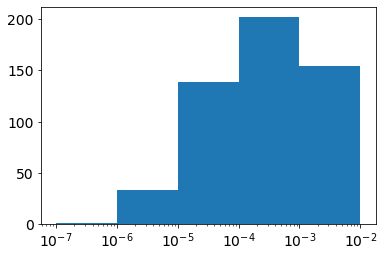

In [787]:
A_pre_non_zero = p_pre_fp[np.abs(p_pre_fp)>0]
bins = [10**x for x in range(-7,-1)]
#bins = [0.1*x for x in range (-30, 30)]
plt.hist(A_pre_non_zero, bins)
plt.xscale('log')

In [826]:
np.max(Q_pre_fp - Q_pre)

0.0004882787795690688

In [63]:
f_try = 2 * np.array([[2, .5], [.5, 1]])

In [65]:
np.linalg.eigvals(f_try)

array([4.41421356, 1.58578644])

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").